In [1]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm

In [56]:
#MODEL = "ConvNet_batch2048_weight1.0_secondpart_30k"
#MODEL = "gonzalobenegas/gpn-brassicales"
MODEL = "ConvNet_batch2048_weight0_secondpart_30k"


d = Path("output/simulated_variants")
variants = pd.read_csv(
    d / "variants.annotated.vcf.gz", sep="\t", header=None, comment="#",
    usecols=[0,1,3,4,7], dtype={0: str},
).rename(columns={0: 'chrom', 1: 'pos', 3: 'ref', 4: 'alt', 7: "INFO"})
variants["consequence"] = variants.INFO.str.replace(
    "CSQ=", ""
).str.split(",").apply(
    lambda x: ",".join(sorted(list(set([y.split("|")[1] for y in x]))))
).drop(columns="INFO")
variants["score"] = pd.read_parquet(d / "vep" / (MODEL + ".parquet")).score.values
variants

,chrom,pos,ref,alt,INFO,consequence,score
0,5,3500000,G,A,CSQ=A|synonymous_variant|LOW|TRS120|AT5G11040|...,synonymous_variant,-0.228212
1,5,3500000,G,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.636478
2,5,3500000,G,T,CSQ=T|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.743758
3,5,3500001,A,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.556498
4,5,3500001,A,G,CSQ=G|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-0.238257
...,...,...,...,...,...,...,...
2999995,5,4499998,C,G,CSQ=G|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.199073
2999996,5,4499998,C,T,CSQ=T|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,0.770390
2999997,5,4499999,G,A,CSQ=A|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,-0.496679
2999998,5,4499999,G,C,CSQ=C|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.561297


In [57]:
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
variants["start"] = variants.pos
variants["end"] = variants.start + 1
variants = bf.coverage(variants, repeats).rename(columns={"coverage": "repeat"})
variants.repeat = variants.repeat.astype(bool)
variants

,chrom,pos,ref,alt,INFO,consequence,score,start,end,repeat
0,5,3500000,G,A,CSQ=A|synonymous_variant|LOW|TRS120|AT5G11040|...,synonymous_variant,-0.228212,3500000,3500001,False
1,5,3500000,G,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.636478,3500000,3500001,False
2,5,3500000,G,T,CSQ=T|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.743758,3500000,3500001,False
3,5,3500001,A,C,CSQ=C|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-1.556498,3500001,3500002,False
4,5,3500001,A,G,CSQ=G|missense_variant|MODERATE|TRS120|AT5G110...,missense_variant,-0.238257,3500001,3500002,False
...,...,...,...,...,...,...,...,...,...,...
2999995,5,4499998,C,G,CSQ=G|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.199073,4499998,4499999,False
2999996,5,4499998,C,T,CSQ=T|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,0.770390,4499998,4499999,False
2999997,5,4499999,G,A,CSQ=A|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,-0.496679,4499999,4500000,False
2999998,5,4499999,G,C,CSQ=C|missense_variant|MODERATE|AT5G13950|AT5G...,missense_variant,1.561297,4499999,4500000,False


In [58]:
variants.consequence = variants.consequence.str.replace("_variant", "")

variants.loc[variants["repeat"], "consequence"] = "repeat"

#variants.loc[((variants["repeat"] & (variants.consequence=="intergenic"))), "consequence"] = "intergenic_repeat"
#variants.consequence.replace("intergenic", "intergenic_non_repeat", inplace=True)

variants.consequence.replace("non_coding_transcript_exon", "nc_transcript_exon", inplace=True)

In [59]:
c_counts = variants.consequence.value_counts()
c_counts[:20]

consequence
missense                                            636445
intron                                              500514
intergenic                                          356802
synonymous                                          194845
upstream_gene                                       193380
downstream_gene                                     136770
repeat                                              107730
3_prime_UTR                                          91155
5_prime_UTR                                          77640
downstream_gene,upstream_gene                        74220
3_prime_UTR,downstream_gene                          57369
downstream_gene,missense                             46607
3_prime_UTR,upstream_gene                            40758
stop_gained                                          38956
5_prime_UTR,upstream_gene                            34014
splice_polypyrimidine_tract&intron                   31266
5_prime_UTR,downstream_gene                 

In [60]:
c_all = variants.consequence.unique()
c_1 = np.array([c for c in c_all if "," not in c])
c_2 = np.array([c for c in c_1 if "&" not in c])
len(c_all), len(c_1), len(c_2)

(836, 37, 17)

In [61]:
consequences_to_plot = c_2[c_counts[c_2]>=1000]
c_counts[consequences_to_plot]

consequence
synonymous            194845
missense              636445
stop_gained            38956
splice_donor            6984
intron                500514
splice_acceptor         6942
repeat                107730
3_prime_UTR            91155
downstream_gene       136770
intergenic            356802
upstream_gene         193380
5_prime_UTR            77640
start_lost              1338
nc_transcript_exon      8427
Name: count, dtype: int64

In [62]:
# simple reordering
consequences_to_plot = variants[variants.consequence.isin(consequences_to_plot)].groupby(
    "consequence"
).score.quantile(0.01)[consequences_to_plot].sort_values().index.values
consequences_to_plot

array(['stop_gained', 'splice_acceptor', 'splice_donor', 'start_lost',
       'missense', 'repeat', 'nc_transcript_exon', 'intergenic',
       '5_prime_UTR', 'upstream_gene', 'synonymous', 'downstream_gene',
       'intron', '3_prime_UTR'], dtype=object)

In [63]:
p1 = variants[variants.consequence.isin(consequences_to_plot)].groupby("consequence").score.quantile(0.01).sort_values()
p1

consequence
stop_gained          -9.677655
splice_acceptor      -9.538304
splice_donor         -9.474167
start_lost           -8.753291
missense             -8.637904
repeat               -7.738199
nc_transcript_exon   -6.239280
intergenic           -5.351998
5_prime_UTR          -3.961388
upstream_gene        -3.918046
synonymous           -3.678083
downstream_gene      -3.172461
intron               -3.108578
3_prime_UTR          -2.838430
Name: score, dtype: float64

In [64]:
p10 = variants[variants.consequence.isin(consequences_to_plot)].groupby("consequence").score.quantile(0.1).sort_values()
p10

consequence
splice_donor         -7.975476
stop_gained          -7.880916
splice_acceptor      -7.779341
start_lost           -6.838280
missense             -5.672316
repeat               -5.299924
nc_transcript_exon   -2.949057
synonymous           -2.077757
5_prime_UTR          -2.007228
intergenic           -1.578354
upstream_gene        -1.574706
intron               -1.569813
3_prime_UTR          -1.449444
downstream_gene      -1.408589
Name: score, dtype: float64

In [65]:
p1["missense"] - p1["repeat"], p10["missense"] - p10["repeat"]

(-0.8997056865692139, -0.372391557693482)

In [66]:
V_r = variants.query('consequence == "repeat"')
(V_r.score < p1["missense"]).mean(), (V_r.score < p10["missense"]).mean()

(0.0019678826696370557, 0.08240972802376312)

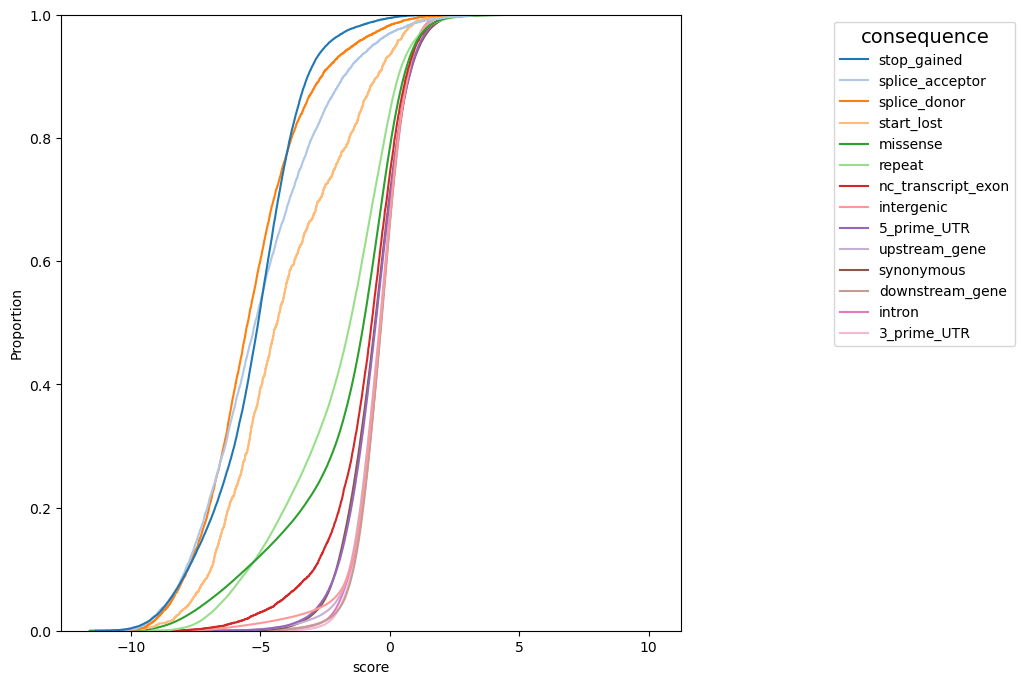

In [10]:
plt.figure(figsize=(8, 8))
g = sns.ecdfplot(
    data=variants[variants.consequence.isin(consequences_to_plot)],
    hue="consequence",
    hue_order=consequences_to_plot,
    x="score",
    palette="tab20"
)
sns.move_legend(g, "upper right", bbox_to_anchor=(1.55, 1), ncol=1, title_fontsize=14)

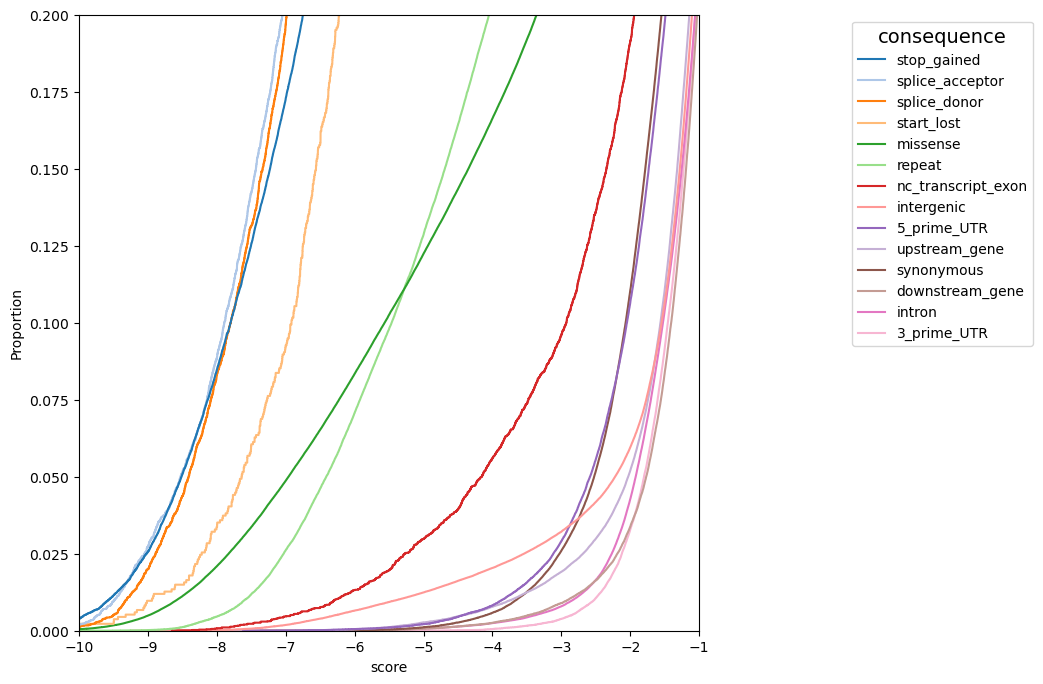

In [11]:
plt.figure(figsize=(8, 8))
g = sns.ecdfplot(
    data=variants[variants.consequence.isin(consequences_to_plot)],
    hue="consequence",
    hue_order=consequences_to_plot,
    x="score",
    palette="tab20"
)
plt.xlim([-10, -1])
plt.ylim([0, 0.2])
sns.move_legend(g, "upper right", bbox_to_anchor=(1.55, 1), ncol=1, title_fontsize=14)

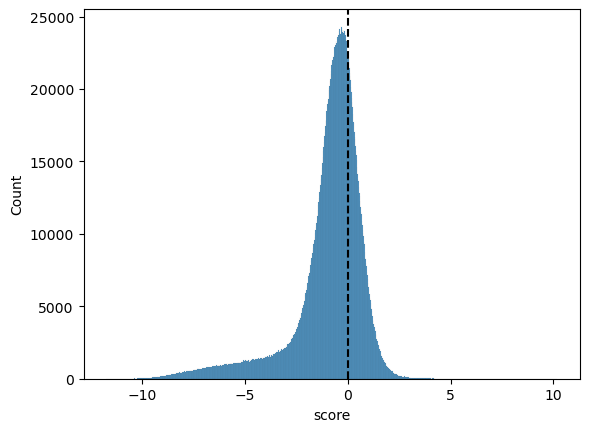

In [12]:
sns.histplot(
    data=variants,
    x="score"
)
plt.axvline(0, linestyle="--", color="black")

Text(0.5, 0, 'GPN score')

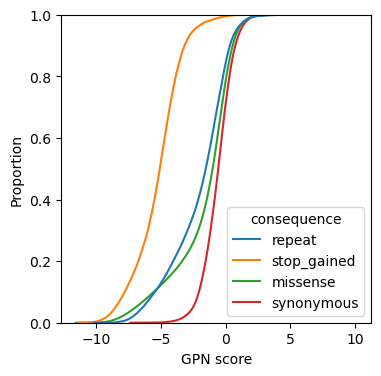

In [13]:
hist_consequences = [
    #"start_lost",
    #"intergenic_repeat",
    "repeat",
    "stop_gained",
    "missense",
    "synonymous",
    #"stop_lost",
    #"intron_variant",
    #"upstream_gene_variant",
    #"downstream_gene_variant",
    #"splice_acceptor_variant",
    #"splice_donor_variant",
    #"3_prime_UTR_variant",
    #"5_prime_UTR_variant",
    #"nc_transcript_exon_variant",
]
plt.figure(figsize=(4,4))
g = sns.ecdfplot(
    data=variants[variants.consequence.isin(hist_consequences)],
    x="score",
    hue="consequence",
    hue_order=hist_consequences,
)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("GPN score")
#plt.savefig("output/plots/ism_scores_cdf_repeatweight0.1.svg", bbox_inches="tight")

In [14]:
# do the example here:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html

In [15]:
score_col = "GPN score"
df = variants[variants.consequence.isin(consequences_to_plot)].copy()
df["g"] = df.consequence
df[score_col] = df.score
df['consequence'] = pd.Categorical(df['consequence'], categories=consequences_to_plot, ordered=True)
df = df.sort_values("consequence")
df

,chrom,pos,ref,alt,INFO,consequence,score,start,end,repeat,g,GPN score
1912668,5,4137556,C,A,CSQ=A|stop_gained|HIGH|5-FCL|AT5G13050|Transcr...,stop_gained,-3.378193,4137556,4137557,False,stop_gained,-3.378193
2961369,5,4487123,T,A,CSQ=A|stop_gained|HIGH|AT5G13920|AT5G13920|Tra...,stop_gained,-5.516420,4487123,4487124,False,stop_gained,-5.516420
378939,5,3626313,T,A,CSQ=A|stop_gained|HIGH|AT5G11360|AT5G11360|Tra...,stop_gained,-4.378013,3626313,3626314,False,stop_gained,-4.378013
1354109,5,3951369,A,T,CSQ=T|stop_gained|HIGH|AT5G12220|AT5G12220|Tra...,stop_gained,-2.015215,3951369,3951370,False,stop_gained,-2.015215
2778543,5,4426181,C,A,CSQ=A|stop_gained|HIGH|SMT1|AT5G13710|Transcri...,stop_gained,-3.379505,4426181,4426182,False,stop_gained,-3.379505
...,...,...,...,...,...,...,...,...,...,...,...,...
2870581,5,4456860,G,C,CSQ=C|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,-0.295462,4456860,4456861,False,3_prime_UTR,-0.295462
2870580,5,4456860,G,A,CSQ=A|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,0.030404,4456860,4456861,False,3_prime_UTR,0.030404
2870579,5,4456859,T,G,CSQ=G|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,-1.432974,4456859,4456860,False,3_prime_UTR,-1.432974
2870591,5,4456863,A,T,CSQ=T|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,-0.051219,4456863,4456864,False,3_prime_UTR,-0.051219


In [16]:
q = 1/2000
x_left, x_right = df[score_col].quantile(q), df[score_col].quantile(1-q)
x_left, x_right

(-9.649878258705138, 3.4162388777732366)

In [17]:
df

,chrom,pos,ref,alt,INFO,consequence,score,start,end,repeat,g,GPN score
1912668,5,4137556,C,A,CSQ=A|stop_gained|HIGH|5-FCL|AT5G13050|Transcr...,stop_gained,-3.378193,4137556,4137557,False,stop_gained,-3.378193
2961369,5,4487123,T,A,CSQ=A|stop_gained|HIGH|AT5G13920|AT5G13920|Tra...,stop_gained,-5.516420,4487123,4487124,False,stop_gained,-5.516420
378939,5,3626313,T,A,CSQ=A|stop_gained|HIGH|AT5G11360|AT5G11360|Tra...,stop_gained,-4.378013,3626313,3626314,False,stop_gained,-4.378013
1354109,5,3951369,A,T,CSQ=T|stop_gained|HIGH|AT5G12220|AT5G12220|Tra...,stop_gained,-2.015215,3951369,3951370,False,stop_gained,-2.015215
2778543,5,4426181,C,A,CSQ=A|stop_gained|HIGH|SMT1|AT5G13710|Transcri...,stop_gained,-3.379505,4426181,4426182,False,stop_gained,-3.379505
...,...,...,...,...,...,...,...,...,...,...,...,...
2870581,5,4456860,G,C,CSQ=C|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,-0.295462,4456860,4456861,False,3_prime_UTR,-0.295462
2870580,5,4456860,G,A,CSQ=A|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,0.030404,4456860,4456861,False,3_prime_UTR,0.030404
2870579,5,4456859,T,G,CSQ=G|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,-1.432974,4456859,4456860,False,3_prime_UTR,-1.432974
2870591,5,4456863,A,T,CSQ=T|3_prime_UTR_variant|MODIFIER|AT5G13810|A...,3_prime_UTR,-0.051219,4456863,4456864,False,3_prime_UTR,-0.051219


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


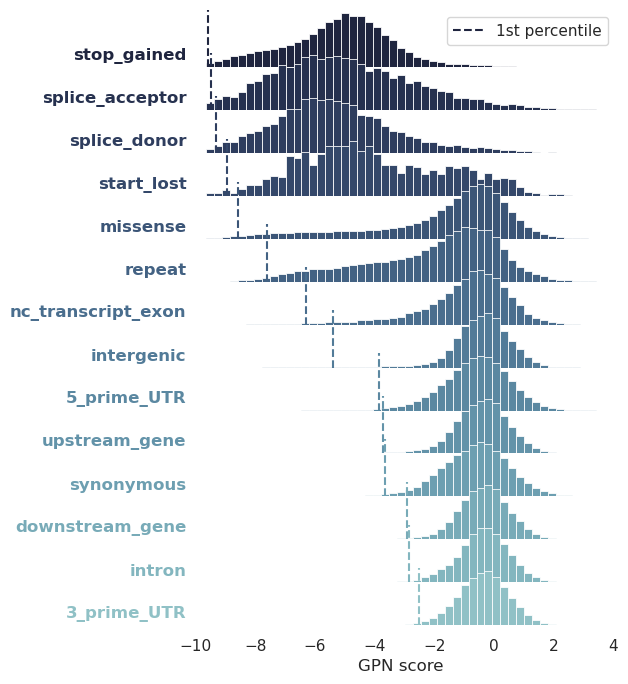

In [18]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(len(consequences_to_plot), rot=-.25, light=.7, reverse=True)
g = sns.FacetGrid(
    df, row="g", hue="g",
    aspect=10,#15,
    #height=.5,  # doesn't work
    #height=1, # this works
    height=0.5,
    palette=pal,
    sharey=False,
)

g.map(
    sns.histplot,
    score_col,
    bins=np.linspace(x_left, x_right, 50),
    alpha=1,
    fill=True,
    stat="density",
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0, .2, label, fontweight="bold", color=color,
        ha="right",
        va="center", transform=ax.transAxes
    )
g.map(label, score_col)

def add_quantile(x, color, label):
    ax = plt.gca()
    artist = ax.axvline(x.quantile(0.01), ls='--', color=color)
    
g.map(add_quantile, score_col)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);
import matplotlib

artist = [c for c in g.axes[0,0].get_children() if type(c)==matplotlib.lines.Line2D][0]
legend = g.axes[0,0].legend([artist], ["1st percentile"], loc="upper right")
legend.get_frame().set_facecolor('white')
#plt.savefig("output/plots/vep_simulated.pdf", bbox_inches="tight")